In [83]:
!pip install tslearn
!pip install torch


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\Ryan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\Ryan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [84]:
import tslearn
import tslearn.datasets as ds
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import copy
import matplotlib.pyplot as plt
from Models.LAFS import *


In [85]:
# ds.UCR_UEA_datasets().list_datasets()

In [86]:
trainX, trainY, testX, testY = ds.UCR_UEA_datasets().load_dataset(
        "MotorImagery")

In [87]:
print(trainX.shape)
print(testX.shape)
print(len(np.unique(trainY))," Classes")

(278, 3000, 64)
(100, 3000, 64)
2  Classes


In [88]:
# plt.plot(trainX[0,...,27])

In [89]:
def get_mean_std(trainX,dim = (0,1)):  ## normalize across subject and time, for each feature (7)
    mean_channel = np.nanmean(trainX,axis = dim, keepdims = True)
    std_channel = np.nanstd(trainX,axis = dim,keepdims =True)
    return mean_channel,std_channel

In [90]:
mean_channel,std_channel = get_mean_std(trainX)
trainX = (trainX - mean_channel)/(std_channel + 1e-8)
testX = (testX - mean_channel)/(std_channel + 1e-8)

In [91]:
## Average Pooling to Reduce and smooth the size of the sequence 
trainX = torch.tensor(trainX)
testX = torch.tensor(testX)

trainX = F.avg_pool1d(trainX.permute(0,2,1),10,10).permute(0,2,1)
trainX = np.array(trainX.detach())

testX = F.avg_pool1d(testX.permute(0,2,1),10,10).permute(0,2,1)
testX = np.array(testX.detach())

In [92]:
### Label encoding 
unique_values = np.unique(trainY)
unique_values = [i for i in unique_values if i is not np.nan]
mapping = {value: idx for idx, value in enumerate(unique_values)}
print(mapping)
for v in unique_values:

    trainY[trainY == v] = mapping[v]
    testY[testY ==v] = mapping[v]
trainY = np.long(trainY)
testY = np.long(testY)

{np.str_('finger'): 0, np.str_('tongue'): 1}


In [104]:
## Simple CNN example
class SimpleCNN_LAFS(nn.Module):
    def __init__(self, input_size,sequence_length,filter_size = 32,kernel_size = 3, depth = 2, n_class = 2, lafs_heads = 4, use_lafs = True):
        super(SimpleCNN_LAFS, self).__init__()
        self.lafs = LAFS(input_size,sequence_length,k = sequence_length//4, lafs_heads = lafs_heads,attention_heads = 4)
        self.depth = depth
        self.use_lafs = use_lafs
        self.conv_list = nn.ModuleList()
        if use_lafs:
            self.conv_list.append(nn.Conv1d(lafs_heads,filter_size,kernel_size = kernel_size,padding = 0))
        else:
            self.conv_list.append(nn.Conv1d(input_size,filter_size,kernel_size = kernel_size,padding = 0))

        for d in range(1,depth):
            self.conv_list.append(nn.Conv1d(filter_size,filter_size,kernel_size = kernel_size,padding = 0))

        self.out = nn.Linear(filter_size, n_class)

    def forward(self,x):
        
        ## Input X should be (Batch size, Time Steps,Features)
        if self.use_lafs:
            x, weights = self.lafs(x,training = True)
        else:
            weights = None
        x = x.permute(0,2,1)
        x = self.conv_list[0](x)
        x = torch.relu(x)
        for d in range(1,self.depth):
            x = self.conv_list[d](x)
            x = torch.relu(x)

        x,ind = torch.max(x,dim = -1)
        x = self.out(x)
        return x, weights

In [94]:
## Define simple train function 

def create_data_loaders(X,Y, batch_size = 1, shuffle = False):
    X_torch = torch.Tensor(X).float()
    Y_torch = torch.Tensor(Y).long()
    train = TensorDataset(X_torch,Y_torch) 
    train_data_loader = DataLoader(train, shuffle=shuffle, batch_size = batch_size) 
    return train_data_loader

def train(model, train_dataloader, test_dataloader, lr = .003, num_epochs = 100,early_stopping = 20):
    es = early_stopping
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()
    max_val_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        for i, (x,y) in enumerate(train_dataloader):  
            outputs, weights = model(x)
            loss = loss_function(outputs,y.long())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        model.eval()
        val_acc = 0
        output_ = torch.zeros((0))
        labels_ = torch.zeros((0))
        for i, (x,y) in enumerate(test_dataloader):  
            outputs, weights = model(x)
            outputs = torch.argmax(outputs,dim = -1)
            output_ = torch.cat([output_,outputs],axis = 0)
            labels_ = torch.cat([labels_,y],axis = 0)
        val_acc = len(output_[output_ == labels_])/len(output_)
        if (val_acc > max_val_acc):
            es = early_stopping
            print("val accuracy increased from " + str(max_val_acc) + " to " + str(val_acc) + " at epoch " + str(epoch) + ". Saving new model.")
            best_model = copy.deepcopy(model)
            max_val_acc = val_acc
        else:
            es = es - 1
        if es <=0:
            break
    return best_model

In [95]:
model = SimpleCNN_LAFS(trainX.shape[-1],trainX.shape[1],filter_size = 8,depth = 1,kernel_size=5,n_class = 2,use_lafs = False)
train_data_loader, test_data_loader = create_data_loaders(trainX,trainY,batch_size = 4,shuffle = True), create_data_loaders(testX,testY,batch_size = 100)
model = train(model, train_data_loader,test_data_loader)

val accuracy increased from 0.0 to 0.38 at epoch 0. Saving new model.
val accuracy increased from 0.38 to 0.51 at epoch 1. Saving new model.
val accuracy increased from 0.51 to 0.53 at epoch 4. Saving new model.
val accuracy increased from 0.53 to 0.55 at epoch 10. Saving new model.


In [105]:
model = SimpleCNN_LAFS(trainX.shape[-1],trainX.shape[1],filter_size = 8,depth = 1,kernel_size=5,n_class = 2,use_lafs = True,lafs_heads = 8)
train_data_loader, test_data_loader = create_data_loaders(trainX,trainY,batch_size = 4,shuffle = True), create_data_loaders(testX,testY,batch_size = 100)
model = train(model, train_data_loader,test_data_loader)

val accuracy increased from 0.0 to 0.48 at epoch 0. Saving new model.
val accuracy increased from 0.48 to 0.62 at epoch 2. Saving new model.
val accuracy increased from 0.62 to 0.67 at epoch 13. Saving new model.


In [106]:
model.eval()
pred, weights = model(torch.tensor(testX).float())

In [107]:
weights = weights.squeeze(1).detach()
weights = np.array(weights)
weights.shape

(100, 64)

In [108]:
feature_names = ['EEG Channel ' + str(i) for i in np.arange(0,weights.shape[1]).tolist()]
feature_names = np.array(feature_names)

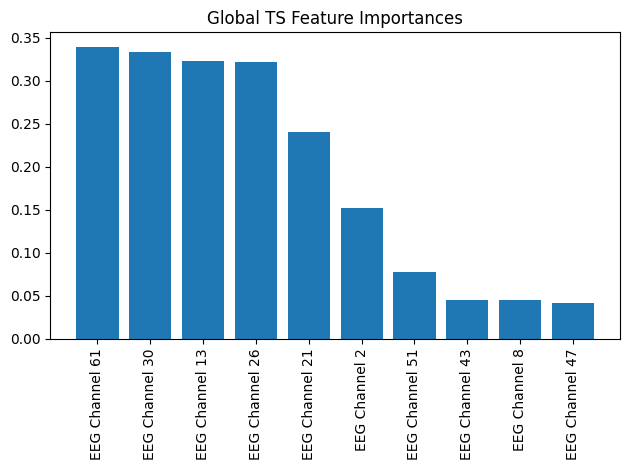

In [109]:
## Global Weights (Only show top 10)
topk = 10
importances = np.mean(weights,axis = 0)
indices = importances.argsort()[::-1]
indices = indices[:topk]
plt.figure()
plt.title("Global TS Feature Importances")
plt.bar(range(len(indices)), importances[indices], align="center")
plt.xticks(range(len(indices)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()


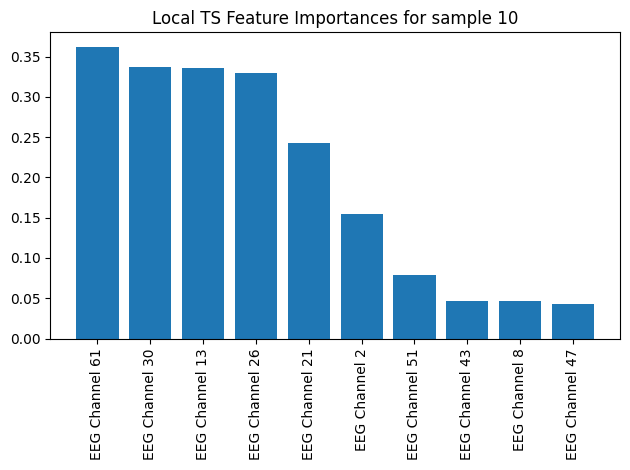

In [110]:
## Local Weights for sample K, (Only show top 10)
sample = 10
topk = 10
importances = weights[sample]
indices = importances.argsort()[::-1]
indices = indices[:topk]
plt.figure()
plt.title("Local TS Feature Importances for sample " + str(sample))
plt.bar(range(len(indices)), importances[indices], align="center")
plt.xticks(range(len(indices)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()